In [949]:
from dataset import FinancialDataset, DataHandler
from trainer_new import PortfolioTrainer
from models import NN_Sharpe
import matplotlib.pyplot as plt

In [950]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Class FinancialDataset

In [951]:
financial_dataset = FinancialDataset(synthetic=True, n_simul=10)

[*********************100%***********************]  2 of 2 completed


In [952]:
financial_dataset.dataset

tensor([[[-0.0077,  0.0366],
         [ 0.0051,  0.0158],
         [ 0.0205, -0.0050],
         ...,
         [-0.0007,  0.0152],
         [ 0.0119,  0.0175],
         [-0.0196,  0.0006]]])

In [953]:
financial_dataset.dataset_synthetic

tensor([[[-0.0098, -0.0077],
         [-0.0315, -0.0219],
         [-0.0176, -0.0072],
         ...,
         [-0.0368, -0.0159],
         [-0.0175, -0.0056],
         [ 0.0334,  0.0146]],

        [[-0.0252,  0.0103],
         [ 0.0092, -0.0174],
         [ 0.0055, -0.0013],
         ...,
         [-0.0258, -0.0100],
         [ 0.0507,  0.0252],
         [ 0.0060,  0.0212]],

        [[ 0.0077,  0.0011],
         [ 0.0124,  0.0095],
         [ 0.0399,  0.0122],
         ...,
         [-0.0055,  0.0091],
         [ 0.0034,  0.0090],
         [-0.0303, -0.0367]],

        ...,

        [[ 0.0444,  0.0175],
         [-0.0096, -0.0252],
         [-0.0298, -0.0021],
         ...,
         [ 0.0315, -0.0031],
         [ 0.0200,  0.0162],
         [ 0.0066,  0.0174]],

        [[ 0.0218,  0.0183],
         [ 0.0098, -0.0258],
         [ 0.0222,  0.0084],
         ...,
         [-0.0176, -0.0359],
         [-0.0097,  0.0082],
         [-0.0099, -0.0083]],

        [[ 0.0316, -0.0039],
       

10 simulations gaussiennes pour les données synthétiques

torch.Size([10, 3791, 2])


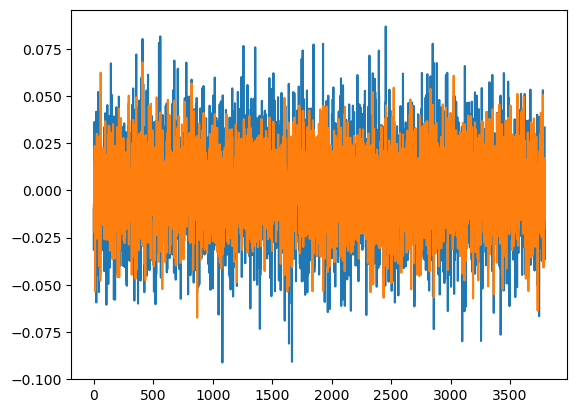

In [954]:
print(financial_dataset.dataset_synthetic.shape)
plt.plot(financial_dataset.dataset_synthetic[0, :, :])

<Axes: xlabel='Date'>

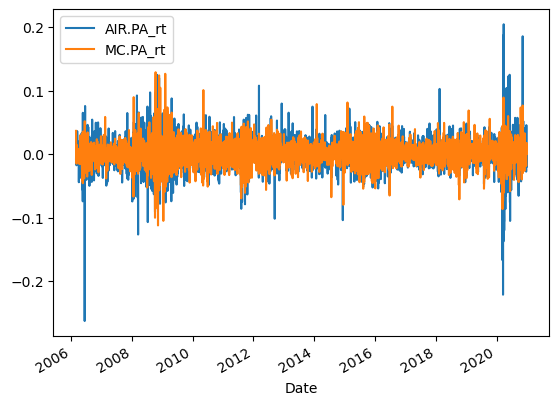

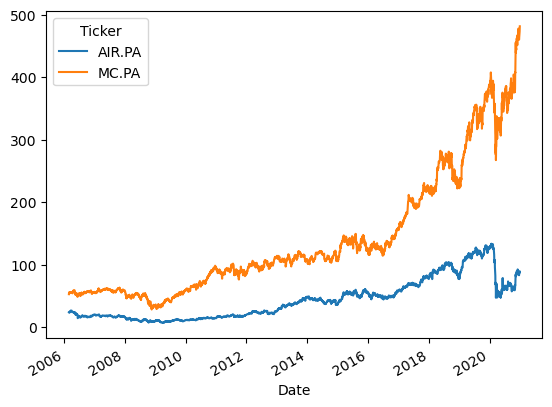

In [955]:
financial_dataset._raw_data['returns'].plot()
financial_dataset._raw_data['prices'].plot()

# dictionnaire qui contient 'prices' et 'returns

# Class DataHandler

In [1141]:
data_handler = DataHandler(
    dataset=financial_dataset,
    initial_train_years=4,
    retrain_years=2,
    rolling_window=20,
    batch_size=1,
    overlap=True,
    shuffle=False,
    on_synthetic=False
)

In [1142]:
for i in range(len(data_handler.periods_train)):
    print(f"TRAIN : {data_handler.periods_train[i]}; TEST : {data_handler.periods_invest[i]}")

TRAIN : (21, 1029); TEST : (1029, 1533)
TRAIN : (1029, 1533); TEST : (1533, 2037)
TRAIN : (1533, 2037); TEST : (2037, 2541)
TRAIN : (2037, 2541); TEST : (2541, 3045)
TRAIN : (2541, 3045); TEST : (3045, 3549)


### Méthode _compute_data

In [1143]:
data_handler._compute_data(start=0,
                           end=100,
                           training=True,
                           )

"""
return : 
    rolling_window de la data basé sur l'overlap/training
    si training : retourne également le Y associé
"""

"\nreturn : \n    rolling_window de la data basé sur l'overlap/training\n    si training : retourne également le Y associé\n"

In [1144]:
rolling_data = data_handler._compute_data(start=200,
                           end=300,
                           training=True)


In [1145]:
dataloader, xtest, dates = data_handler.load_period(0)

Training period from 21 to 1029
Investment period from 1029 to 1533


In [1146]:
len(xtest)

for sim in range(data_handler.n_simul):
    print(sim*(dates[3]-dates[2]), (sim+1)*(dates[3]-dates[2]))

0 504


In [1147]:
len(xtest[0:5040])

504

In [1148]:
for batch_x, batch_y in dataloader:
    print(batch_x, batch_y)

tensor([[[ 0.0051,  0.0158],
         [ 0.0205, -0.0050],
         [-0.0053, -0.0081],
         [-0.0177, -0.0151],
         [ 0.0083,  0.0115],
         [ 0.0156,  0.0145],
         [ 0.0060,  0.0093],
         [-0.0156, -0.0018],
         [ 0.0139, -0.0025],
         [ 0.0362,  0.0043],
         [ 0.0301,  0.0018],
         [ 0.0053,  0.0018],
         [-0.0023, -0.0049],
         [-0.0032,  0.0000],
         [ 0.0202, -0.0019],
         [ 0.0072,  0.0025],
         [-0.0065, -0.0062],
         [-0.0074, -0.0006],
         [-0.0029,  0.0037],
         [ 0.0069,  0.0056]]]) tensor([[[ 0.0205, -0.0050],
         [-0.0053, -0.0081],
         [-0.0177, -0.0151],
         [ 0.0083,  0.0115],
         [ 0.0156,  0.0145],
         [ 0.0060,  0.0093],
         [-0.0156, -0.0018],
         [ 0.0139, -0.0025],
         [ 0.0362,  0.0043],
         [ 0.0301,  0.0018],
         [ 0.0053,  0.0018],
         [-0.0023, -0.0049],
         [-0.0032,  0.0000],
         [ 0.0202, -0.0019],
         [ 0

# Class PortfolioTrainer

In [1165]:
trainer = PortfolioTrainer(
    model=NN_Sharpe(input_size=data_handler.n_assets,
                    hidden_size=5,
                    num_layers=1,
                    
                    output_size=data_handler.n_assets,
                    temperature=4),
    data_handler=data_handler,
    device='cpu',
    epochs=5,
    lr=0.01,
    weight_decay=0,
)

In [1166]:
trainer.train()

Training period from 21 to 1029
Investment period from 1029 to 1533


100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


-0.029063893204274504
1029 1533
Training period from 1029 to 1533
Investment period from 1533 to 2037


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


-0.08716024275029971
1533 2037
Training period from 1533 to 2037
Investment period from 2037 to 2541


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


-0.09575912366468285
2037 2541
Training period from 2037 to 2541
Investment period from 2541 to 3045


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


-0.031127590885190005
2541 3045
Training period from 2541 to 3045
Investment period from 3045 to 3549


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

-0.12572789795859923
3045 3549


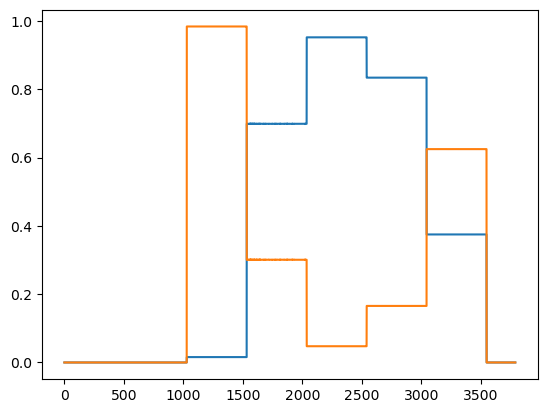

In [1168]:


plt.plot(trainer.weights[0, :, :])